In [1]:
# Cell 1: Imports
import pandas as pd
import os
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from functools import lru_cache
import matplotlib.pyplot as plt
#%matplotlib inline  # For inline plotting in Jupyter

In [2]:
# Cell 2: Data Loading with Caching

In [3]:
iMAGE_PIXEL = 100
BATCH_SIZE = 16
@lru_cache(maxsize=1000)
def load_and_preprocess_image(image_path):
    """Load and preprocess an image, cached by file path."""
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image at {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv2.resize(img, (iMAGE_PIXEL, iMAGE_PIXEL))

def load_images_with_data(image_dir="F:/Pheonix/Thesis/Project/Code/AQI Index/.venv/Dev/Data/cleaned_folder",
                         csv_file="F:/Pheonix/Thesis/Project/Code/AQI Index/.venv/Dev/Data/cleaned_data.csv"):
    """Load images and data with caching."""
    df = pd.read_csv(csv_file)
    image_data_list = []
    
    for _, row in df.iterrows():
        image_name = row['Filename']
        image_path = os.path.join(image_dir, image_name)
        if os.path.exists(image_path):
            try:
                img_resized = load_and_preprocess_image(image_path)
                values = row.to_dict()
                values['image'] = img_resized
                image_data_list.append(values)
            except Exception as e:
                print(f"Error loading image {image_name}: {e}")
        else:
            print(f"Warning: Image '{image_name}' not found in '{image_dir}'.")
    return image_data_list

# Load data
image_data_list = load_images_with_data()
print(f"Loaded {len(image_data_list)} images")

Loaded 10610 images


In [3]:
iMAGE_PIXEL = 100
BATCH_SIZE = 16
@lru_cache(maxsize=1000)
def load_and_preprocess_image(image_path):
    """Load and preprocess an image, cached by file path."""
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image at {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv2.resize(img, (iMAGE_PIXEL, iMAGE_PIXEL))

def load_images_with_data(image_dir="F:/Pheonix/Thesis/Project/Code/AQI Index/.venv/Dev/Data/cleaned_folder",
                         csv_file="F:/Pheonix/Thesis/Project/Code/AQI Index/.venv/Dev/Data/cleaned_data.csv"):
    """Load images and data with caching."""
    df = pd.read_csv(csv_file)
    image_data_list = []
    
    for _, row in df.iterrows():
        image_name = row['Filename']
        image_path = os.path.join(image_dir, image_name)
        if os.path.exists(image_path):
            try:
                img_resized = load_and_preprocess_image(image_path)
                values = row.to_dict()
                values['image'] = img_resized
                image_data_list.append(values)
            except Exception as e:
                print(f"Error loading image {image_name}: {e}")
        else:
            print(f"Warning: Image '{image_name}' not found in '{image_dir}'.")
    return image_data_list

# Load data
image_data_list = load_images_with_data()
print(f"Loaded {len(image_data_list)} images")

Loaded 10610 images


In [3]:
iMAGE_PIXEL = 100
BATCH_SIZE = 16
@lru_cache(maxsize=1000)
def load_and_preprocess_image(image_path):
    """Load and preprocess an image, cached by file path."""
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image at {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv2.resize(img, (iMAGE_PIXEL, iMAGE_PIXEL))

def load_images_with_data(image_dir="F:/Pheonix/Thesis/Project/Code/AQI Index/.venv/Dev/Data/cleaned_folder",
                         csv_file="F:/Pheonix/Thesis/Project/Code/AQI Index/.venv/Dev/Data/cleaned_data.csv"):
    """Load images and data with caching."""
    df = pd.read_csv(csv_file)
    image_data_list = []
    
    for _, row in df.iterrows():
        image_name = row['Filename']
        image_path = os.path.join(image_dir, image_name)
        if os.path.exists(image_path):
            try:
                img_resized = load_and_preprocess_image(image_path)
                values = row.to_dict()
                values['image'] = img_resized
                image_data_list.append(values)
            except Exception as e:
                print(f"Error loading image {image_name}: {e}")
        else:
            print(f"Warning: Image '{image_name}' not found in '{image_dir}'.")
    return image_data_list

# Load data
image_data_list = load_images_with_data()
print(f"Loaded {len(image_data_list)} images")

Loaded 10610 images


In [4]:
@lru_cache(maxsize=1000)
def segment_sky(image_tuple):
    """Segment sky from image, cached by image content."""
    # Reshape the flattened tuple back to (224, 224, 3)
    image = np.array(image_tuple, dtype=np.uint8).reshape(iMAGE_PIXEL, iMAGE_PIXEL, 3)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower_blue = np.array([90, 50, 50])
    upper_blue = np.array([130, 255, 255])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    return cv2.bitwise_and(image, image, mask=mask)

def prepare_dataset(image_data_list):
    """Prepare dataset with caching."""
    X = []
    y_dict = {'AQI': [], 'PM2.5': [], 'PM10': [], 'O3': [], 'CO': [], 'SO2': [], 'NO2': []}
    
    for data in image_data_list:
        # Convert 3D image array to tuple for caching
        img_tuple = tuple(data['image'].ravel())  # ravel() is equivalent to flatten()
        sky_img = segment_sky(img_tuple)
        sky_img = preprocess_input(sky_img)
        X.append(sky_img)
        for param in y_dict.keys():
            y_dict[param].append(data[param])
    
    return np.array(X), {k: np.array(v) for k, v in y_dict.items()}

# Prepare dataset
X, y_dict = prepare_dataset(image_data_list)
print(f"Dataset shape: X={X.shape}, y_dict keys={list(y_dict.keys())}")

Dataset shape: X=(10610, 100, 100, 3), y_dict keys=['AQI', 'PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2']


In [4]:
@lru_cache(maxsize=1000)
def segment_sky(image_tuple):
    """Segment sky from image, cached by image content."""
    # Reshape the flattened tuple back to (224, 224, 3)
    image = np.array(image_tuple, dtype=np.uint8).reshape(iMAGE_PIXEL, iMAGE_PIXEL, 3)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower_blue = np.array([90, 50, 50])
    upper_blue = np.array([130, 255, 255])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    return cv2.bitwise_and(image, image, mask=mask)

def prepare_dataset(image_data_list):
    """Prepare dataset with caching."""
    X = []
    y_dict = {'AQI': [], 'PM2.5': [], 'PM10': [], 'O3': [], 'CO': [], 'SO2': [], 'NO2': []}
    
    for data in image_data_list:
        # Convert 3D image array to tuple for caching
        img_tuple = tuple(data['image'].ravel())  # ravel() is equivalent to flatten()
        sky_img = segment_sky(img_tuple)
        sky_img = preprocess_input(sky_img)
        X.append(sky_img)
        for param in y_dict.keys():
            y_dict[param].append(data[param])
    
    return np.array(X), {k: np.array(v) for k, v in y_dict.items()}

# Prepare dataset
X, y_dict = prepare_dataset(image_data_list)
print(f"Dataset shape: X={X.shape}, y_dict keys={list(y_dict.keys())}")

Dataset shape: X=(10610, 100, 100, 3), y_dict keys=['AQI', 'PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2']


In [5]:
def build_cnn_model(input_shape=(iMAGE_PIXEL, iMAGE_PIXEL, 3)):
    """Build the CNN model."""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Example model summary
model = build_cnn_model()
model.summary()

C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
def train_models(X, y_dict):
    """Train models for each parameter and report data counts."""
    models = {}
    histories = {}
    
    for param, y_values in y_dict.items():
        print(f"\nTraining model for {param}")
        X_train, X_test, y_train, y_test = train_test_split(X, y_values, test_size=0.2, random_state=42)
        print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")  # Data counts
        print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
        model = build_cnn_model()
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                           epochs=20, batch_size=BATCH_SIZE, verbose=1)
        models[param] = model
        histories[param] = history
    return models, histories

# Train models
models, histories = train_models(X, y_dict)


Training model for AQI
Training samples: 8488, Testing samples: 2122
X_train shape: (8488, 100, 100, 3), X_test shape: (2122, 100, 100, 3)
Epoch 1/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 30s 54ms/step - loss: 13662.6523 - mae: 87.5561 - val_loss: 8250.3535 - val_mae: 69.9433
Epoch 2/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 29s 54ms/step - loss: 9704.5635 - mae: 73.8546 - val_loss: 7194.1016 - val_mae: 64.9491
Epoch 3/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 28s 53ms/step - loss: 8365.1172 - mae: 67.6049 - val_loss: 6916.3853 - val_mae: 58.9404
Epoch 4/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 28s 53ms/step - loss: 7322.0024 - mae: 63.1193 - val_loss: 6441.8311 - val_mae: 55.8212
Epoch 5/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 29s 55ms/step - loss: 6740.8184 - mae: 60.2651 - val_loss: 6699.6675 - val_mae: 57.3516
Epoch 6/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 28s 53ms/step - loss: 6858.9492 - mae: 60.4980 - val_loss: 6444.3096 - val_mae: 60.3619
Epoch 7/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - loss: 6232.0640 - mae: 57.7713 - va

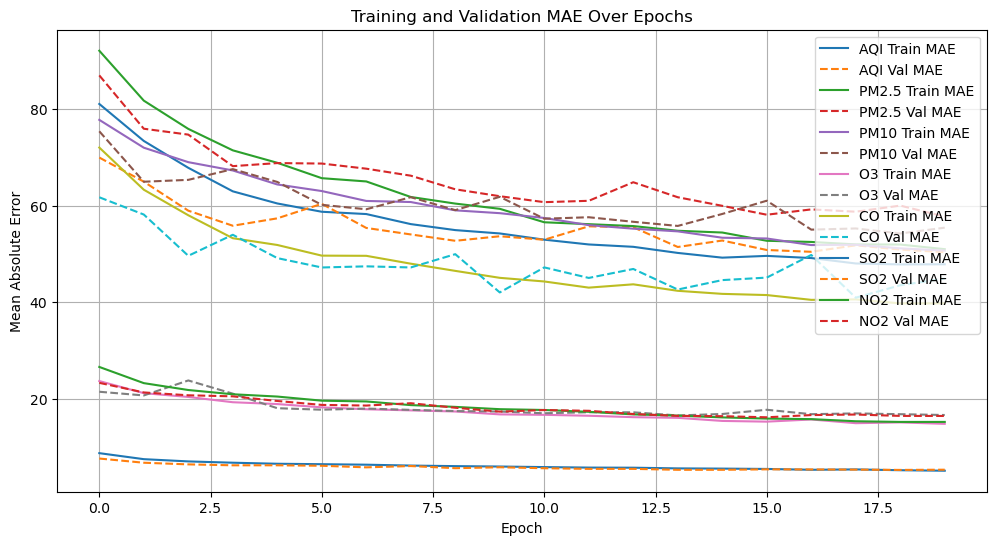

In [7]:
# Plot MAE for each parameter
plt.figure(figsize=(12, 6))
for param, history in histories.items():
    plt.plot(history.history['mae'], label=f'{param} Train MAE')
    plt.plot(history.history['val_mae'], label=f'{param} Val MAE', linestyle='--')
plt.title('Training and Validation MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
def test_model(models, X_test=None, y_test_dict=None, new_image_path=None):
    """Test models with MSE, MAE, R², and data counts."""
    results = {}
    
    if X_test is not None and y_test_dict is not None:
        print(f"\nEvaluating on test data (samples: {X_test.shape[0]})")
        for param, model in models.items():
            test_loss, test_mae = model.evaluate(X_test, y_test_dict[param], verbose=0)
            y_pred = model.predict(X_test, verbose=0).flatten()  # Predictions for R²
            r2 = r2_score(y_test_dict[param], y_pred)  # Calculate R² score
            results[param] = {'MSE': test_loss, 'MAE': test_mae, 'R²': r2}
            print(f"{param} - Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}, R²: {r2:.4f}")
    
    elif new_image_path is not None:
        print("\nPredicting for a new image:")
        img_resized = load_and_preprocess_image(new_image_path)
        img_tuple = tuple(img_resized.ravel())
        sky_img = segment_sky(img_tuple)
        sky_img = preprocess_input(sky_img)
        sky_img = np.expand_dims(sky_img, axis=0)
        
        for param, model in models.items():
            pred = model.predict(sky_img, verbose=0)[0][0]
            results[param] = pred
            print(f"Predicted {param}: {pred:.4f}")
    
    else:
        raise ValueError("Provide either test data or new_image_path")
    return results

# Split data for testing
X_train, X_test, y_train_dict, y_test_dict = {}, {}, {}, {}
for param, y_values in y_dict.items():
    X_train[param], X_test[param], y_train_dict[param], y_test_dict[param] = train_test_split(
        X, y_values, test_size=0.2, random_state=42
    )

# Evaluate on test data
test_results = test_model(models, X_test['AQI'], y_test_dict)

# Predict for a new image
new_image = "F:/Pheonix/Thesis/Project/Code/AQI Index/.venv/Dev/Data/cleaned_folder/BRI_Un_2023-02-02- 12.00-9.jpg"
pred_results = test_model(models, new_image_path=new_image)


Evaluating on test data (samples: 2122)
AQI - Test MSE: 5087.8403, Test MAE: 50.3466, R²: 0.5606
PM2.5 - Test MSE: 7940.9443, Test MAE: 57.7151, R²: 0.5305
PM10 - Test MSE: 7011.0596, Test MAE: 55.4193, R²: 0.4119
O3 - Test MSE: 677.2135, Test MAE: 16.6188, R²: 0.3888
CO - Test MSE: 4394.0083, Test MAE: 44.8831, R²: 0.6920
SO2 - Test MSE: 54.9531, Test MAE: 5.2898, R²: 0.4235
NO2 - Test MSE: 679.4414, Test MAE: 16.4204, R²: 0.4182

Predicting for a new image:
Predicted AQI: 176.0161
Predicted PM2.5: 42.7307
Predicted PM10: 115.0740
Predicted O3: 45.6802
Predicted CO: 60.5270
Predicted SO2: 7.7770
Predicted NO2: 19.4399


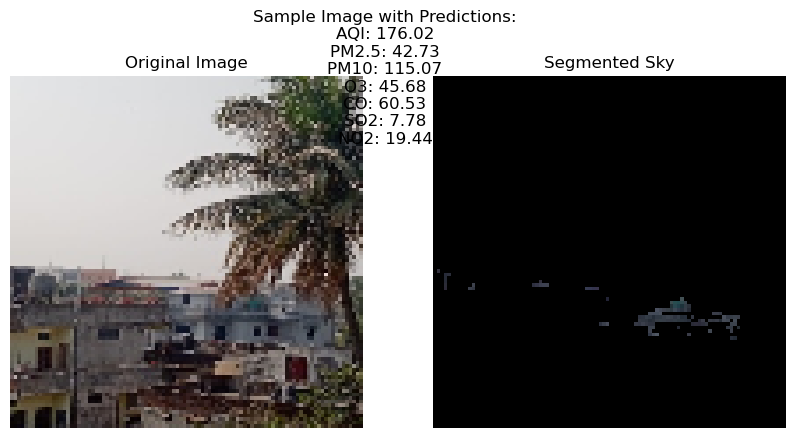

In [9]:
# Display the new image and its predictions
img = load_and_preprocess_image(new_image)
sky_img = segment_sky(tuple(img.flatten()))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sky_img)
plt.title("Segmented Sky")
plt.axis('off')

plt.suptitle("Sample Image with Predictions:\n" + 
             "\n".join(f"{param}: {value:.2f}" for param, value in pred_results.items()))
plt.show()